In [1]:
%matplotlib inline
import math as math
import pandas as pd
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import ipywidgets

In [2]:
folderpath = "*"
file = folderpath + "\\lyftlong\\rand_agents_table0.csv"
at = pd.read_csv(file)
file = folderpath + "\\lyftlong\\rand_frames_table1.csv"
ft = pd.read_csv(file)
file = folderpath +  "\\lyftlong\\rand_scenes_table1.csv"
st = pd.read_csv(file)
file = folderpath + "\\lyftlong\\rand_tlfaces_table1.csv"
tt = pd.read_csv(file)

In [3]:
def get_scene_splicer():
    transition_indices2 = []
    scene_stamp = np.unique(ft['scene_index'].values)
    for sc in scene_stamp:
        isc = list(ft['scene_index'].values).index(sc)
        transition_indices2.append(isc)
    ti = sorted(transition_indices2)[1:]
    return ti
transition_indices = np.array(get_scene_splicer())

In [4]:
class Scene_Temporal_Info:
    def __init__(self, scene_table: pd.DataFrame):
        # NOTE: scene_table is already filtered to be only 1 scene
        self.scene_table = scene_table
        self.AV_locations = list(zip(list(self.scene_table['ego_translation_x']), 
                                     list(self.scene_table['ego_translation_y'])))
        self.velocities = []
        self.translations = []
        self.unit_dotprods = []
    
    def _unit(self, a: [float, float]) -> [float, float]:
        """Gets the unit of vector a. Returns zero vector if norm causes zero division
        Args:
            a ([float, float]): vector a
        Returns:
            float: the unit of vector a
        """
        norm = self._vector_norm(a)
        if norm == 0:
            return [0.0, 0.0]
        else:
            return [a_i/norm for a_i in a]
    def _vector_norm(self, a: [float]) -> float:
        """Gets the norm of vector a
        Args:
            a ([float, float]): vector a
        Returns:
            float: the norm of both vectors
        """
        return (sum([a_i**2 for a_i in a]))**(1/2)
    def _dotprod(self, a, b) -> float:
        """Gets the dotprod of vectors a and b
        Args:
            a ([float, float]): vector a
            b ([float, float]): vector b
        Returns:
            float: the dotprods of both vectors
        """
        return sum([ai*bi for ai, bi in zip(a, b)])
    def _translation(self, a: [float, float], b: [float, float]) -> [float, float]:
        """Gets the translation coords of points a and b
        Args:
            a ([float, float]): point a
            b ([float, float]): point b
        Returns:
            [float, float]: distance in x and distance in y between both points
        """
        ax, ay = a
        bx, by = b
        return [(bx - ax), (by - ay)]
    def set_velocities(self):
        velocities = []
        self.translations.clear()
        for i in range(1, len(self.AV_locations)):
            pointB = self.AV_locations[i]
            pointA = self.AV_locations[i - 1]
            side_length = self._translation(pointA, pointB)
            self.translations.append(side_length)
            velocity = self._vector_norm(side_length)
            velocities.append(velocity)
        self.velocities = velocities
        assert len(self.translations) == len(self.velocities)
        assert len(self.velocities)+1 == len(self.AV_locations)
        return velocities
    def set_unit_dotprods(self):
        if len(self.translations) == 0:
            self.set_velocities()
        unit_dotprods = []
        for i in range(1, len(self.translations)):
            vectB = self.translations[i]
            vectA = self.translations[i - 1]
            unit_dotprod = self._dotprod(self._unit(vectA), 
                                         self._unit(vectB))
            unit_dotprods.append(unit_dotprod)
        self.unit_dotprods = unit_dotprods
        return unit_dotprods        
    def get_unit_dotprods(self) -> [float]:
        assert self.unit_dotprods != []
        return [0.0, 0.0] + self.unit_dotprods
    def get_velocities(self) -> [float]:
        assert self.velocities != []
        return [0.0] + self.unit_dotprods
    def run(self):
        self.set_velocities()
        self.set_unit_dotprods()

In [5]:
def scene_table_subset(scene_index: int, table: pd.DataFrame = ft) -> pd.DataFrame:
    scene_table = table[table.scene_index == scene_index]
    return scene_table
scene_indices = pd.unique(ft['scene_index'].values)


scene_indices = [ 7827, 15982, 10378,   154,  9380, 15002,  4455,  8285, 10522,
        2810,  1233,  1094,  3475, 13521,  2989,   385, 13242, 15073,
         721,  5601,  9884,  3818,  1372,  8029,  9520, 14617,  3043,
       13122, 13699, 12155, 15371,  5025,  1495,  8679, 13317,   204,
       14294, 11121, 13106, 14812,  8581,  9953,  5475,  8368,  1162,
       12928,  2595, 15782,   378,  3163, 15761,  2259, 15022, 15410,
         665,  4781, 10834, 12188,  1820, 12334, 15643,  2180,  2281,
        6235, 10847, 11405, 10210, 14560,  8968,  4386,  6303, 11197,
       14339,  2013,  9767, 13168, 11383, 14898,   296,  6343, 12055,
         112, 13893, 11414, 15559, 11667, 15367,  2547,   587, 11458,
       13215, 15416, 14090,  2367, 12803,  7992, 10719, 11029,  8566,
       15427]

13699


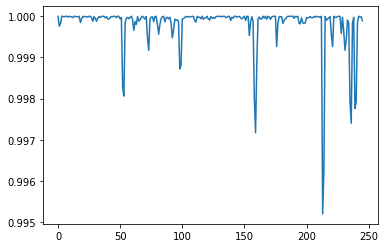

In [6]:
rand_index = np.random.choice(scene_indices)
scene_table = scene_table_subset(rand_index)
tmp_info = Scene_Temporal_Info(scene_table)
tmp_info.run()
print(rand_index)
# plt.ylim(-1, 1)
plt.plot(tmp_info.unit_dotprods)

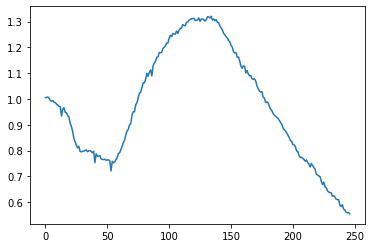

In [7]:
plt.plot(tmp_info.velocities) # in a given scene

In [8]:
all_unit_dotprods = []
for scene_index in scene_indices:
    scene_table = scene_table_subset(scene_index)
    tmp_info = Scene_Temporal_Info(scene_table)
    tmp_info.run()
    all_unit_dotprods = all_unit_dotprods + tmp_info.unit_dotprods

In [9]:
all_velocities = []
all_velocities_adjusted = []
for scene_index in scene_indices:
    scene_table = scene_table_subset(scene_index)
    tmp_info = Scene_Temporal_Info(scene_table)
    tmp_info.run()
    all_velocities_adjusted = all_velocities_adjusted + [tmp_info.velocities[0]] + tmp_info.velocities
    all_velocities = all_velocities + tmp_info.velocities

In [10]:
dpr = pd.DataFrame()
dpr['dot_products'] = all_unit_dotprods

In [11]:
def get_range(dp):
    intervals = [(-1.0, -0.8),
     (-0.8, -0.6),
     (-0.6, -0.4),
     (-0.4, -0.2),
     (-0.2, 0.0),
     (0.0, 0.2),
     (0.2, 0.4),
     (0.4, 0.6),
     (0.6, 0.8),
     (0.8, 1.0)]
    ranks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    for i in range(len(intervals)):
        intvl = intervals[i]
        if dp > intvl[0] and dp <= intvl[1]:
            return ranks[i]
        if dp > 1.0:
            return 0.8
        
dpr['range'] = [get_range(dp) for dp in all_unit_dotprods]

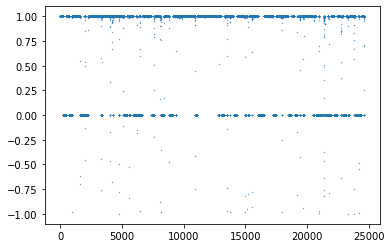

In [12]:
plt.scatter(list(range(24637)), all_unit_dotprods, s=0.1)

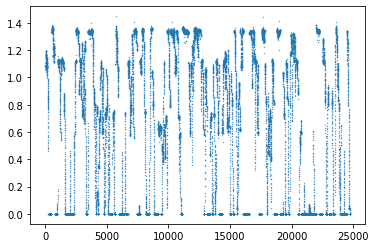

In [13]:
# plt.plot(all_velocities) # in a given scene
plt.scatter(list(range(24737)), all_velocities, s=0.1)

In [14]:
dpr.sort_values('dot_products')

,dot_products,range
4776,-0.999999,-1.0
23277,-0.999878,-1.0
23814,-0.997377,-1.0
20969,-0.996113,-1.0
24189,-0.990124,-1.0
...,...,...
17626,1.000000,0.8
9821,1.000000,0.8
14322,1.000000,0.8
2604,1.000000,0.8


In [15]:
dpr.groupby('range').count()

,dot_products
range,
-1.0,22
-0.8,14
-0.6,11
-0.4,4
-0.2,7671
0.0,3
0.2,6
0.4,16
0.6,21


In [16]:
fta0 = ft['agent_index_interval_start']
fta1 = ft['agent_index_interval_end']

agents_amount = []
for i in range(len(ft)):
    a0i = fta0[i]
    a1i = fta1[i]
    agents_amount.append(a1i - a0i)

Text(0.5, 0, 'Agent amount for a given frame')

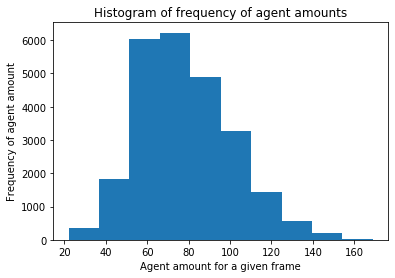

In [17]:
plt.hist(agents_amount)
plt.title("Histogram of frequency of agent amounts")
plt.ylabel("Frequency of agent amount")
plt.xlabel("Agent amount for a given frame")

In [18]:
def MD(at, cx, cy, frame_index):
    # at = agents tables
    # cx = the ai car's x coord in a certain frame
    # cy = the ai car's y coord in a certain frame
    # frame_index = the certain frame
    # 
    # measures the mean distance of the ai car to all the agents in a given frame
    atf = at[at.frame_index == frame_index]
    xs = atf['centroid_x']
    ys = atf['centroid_y']
    cx_array = np.ones((len(atf),)) * cx
    cy_array = np.ones((len(atf),)) * cy
    dcx_array = cx_array - atf['centroid_x']
    dcy_array = cy_array - atf['centroid_y']
    mcxy_array = ((dcx_array**2) + (dcy_array**2))**(1/2)
    return sum(mcxy_array)/len(mcxy_array)
    

mds = []
for i in range(len(ft)):
    frame_index = ft['frame_index'][i]
    cx = ft['ego_translation_x'][i]
    cy = ft['ego_translation_y'][i]
    md = MD(at, cx, cy, frame_index)
    mds.append(md)

ft['Mean Distance from Agents'] = mds

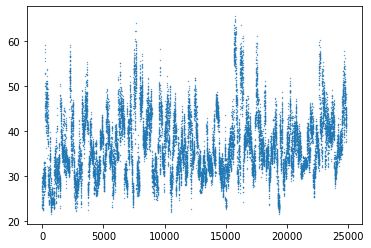

In [21]:
plt.scatter(list(range(len(ft))), ft['Mean Distance from Agents'], s=0.1)

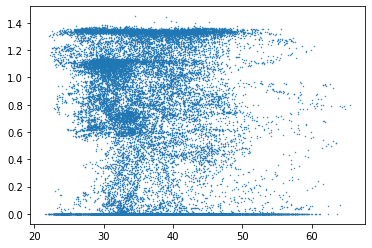

In [22]:
plt.scatter(ft['Mean Distance from Agents'], all_velocities_adjusted, s=0.2)

In [23]:
class Table_Aggregation:
    def __init__(self):
        pass
    def aggregator(self, table: pd.DataFrame = None) -> np.array:
        """ Collapses a table of a certain frame_index in a source table into an array
        Args:
            table (pd.DataFrame): the subset table of the source table with a certain frame_index
        Returns:
            np.array: the horizontal aggregation of the columns in the subsettted table
        """
        return None

In [24]:
class Agent_Aggregation (Table_Aggregation):
    def __init__(self, table: pd.DataFrame = at, columns: [str] = []):
        super(Agent_Aggregation, self).__init__()
        self.table = table # agent_table
        self.columns = columns
        subset_table = table[columns].copy() #[table.frame_index == frame_index][columns].copy()
        self.subset_table = subset_table
    def aggregator(self, table: pd.DataFrame = None) -> pd.DataFrame:
        if table == None:
            table = self.subset_table 
        table['temp_index'] = table['frame_index']
        avgs = table.groupby('temp_index').mean()
        return avgs

In [25]:
at['size'] = at['extent_x'] * at['extent_y']

In [26]:
nn1 = Agent_Aggregation(table = at,
                        columns = [
                            "size",
                            "frame_index",
                            "velocity_x",
                            "velocity_y",
                            "yaw"
                        ])

In [27]:
nn1_table = nn1.aggregator()

In [28]:
ft2 = ft.merge(nn1_table)

* For each scene:
* pair up each frame-row with previous frame (so the first frame is usually discarded)
* put into an object(frame_row0, frame_row1's translation x and y as a discrete angle, one-hot-encoded)
* put into dataset array
* shuffle
* training data = first 80% of data
* split them along their components with list comprehension into train_x, train_y
* do the same with the other 20%

In [29]:
class Frame_Instance:
    def __init__(self, frame_0_array: np.array, frame_1_transl: np.array):
        self.frame_0_array = frame_0_array
        self.frame_1_translation = frame_1_transl

In [30]:
unique_scenes_indices = pd.unique(ft2['scene_index'])

In [31]:
frame_instances = []

In [32]:
def angle_discrete(dx, dy):
    half_angle = np.arctan2(dy, dx)
    if half_angle < 0:
        # print("too small,", half_angle)
        theta = (math.pi + half_angle) + math.pi
    else:
        theta = half_angle
    assert theta >= 0
    assert theta < 2*math.pi
    octer = theta // (math.pi/4)
    return int(octer)

In [33]:
def frame_encoder(frame_0_row, frame_1_row):
    input_ = np.array(frame_0_row)
    x0, y0 = frame_0_row[['ego_translation_x', 'ego_translation_y']].values
    x1, y1 = frame_1_row[['ego_translation_x', 'ego_translation_y']].values
    dx = x1 - x0
    dy = y1 - y0
    one_hot_encoder = np.zeros(8)
    octer = angle_discrete(dx, dy)
    one_hot_encoder[octer] = 1
    return input_, one_hot_encoder

In [34]:
ft2 = ft2.drop([
    'timestamp', 
    'agent_index_interval_start', 
    'agent_index_interval_end',
    'traffic_lights_start', 
    'traffic_lights_end',
    'frame_index'], axis = 1)

In [35]:
for s_i in range(len(unique_scenes_indices)):
    scene_index = unique_scenes_indices[s_i]
    if s_i % 10 == 0:
        print('{0} of 100 scenes done'.format(s_i))
    ft2_scene = ft2[ft2.scene_index == scene_index]
    for i in range(1, len(ft2_scene)):
        frame_1_row = ft2_scene.iloc[i]
        frame_0_row = ft2_scene.iloc[i - 1].drop("scene_index")
        input_, label = frame_encoder(frame_0_row, frame_1_row)
        frame_instance = Frame_Instance(input_, label)
        frame_instances.append(frame_instance)
print("""
Frame Table fully converted into dataset for inputting, labelling
""")

0 of 100 scenes done
10 of 100 scenes done
20 of 100 scenes done
30 of 100 scenes done
40 of 100 scenes done
50 of 100 scenes done
60 of 100 scenes done
70 of 100 scenes done
80 of 100 scenes done
90 of 100 scenes done


In [36]:
assert len(frame_instances) == 24737

In [37]:
np_frame_instances = np.array(frame_instances)

In [38]:
TRAIN_PROPORTION = 0.8
TRAIN_SIZE_INDEXER = int(len(frame_instances) * TRAIN_PROPORTION)
np.random.shuffle(np_frame_instances)

In [39]:
Train_Dataset = np_frame_instances[:TRAIN_SIZE_INDEXER]
Test_Dataset = np_frame_instances[TRAIN_SIZE_INDEXER:]

In [40]:
train_x = []
train_y = []
for frame_instance in Train_Dataset:
    train_xi = frame_instance.frame_0_array
    train_x.append(train_xi)
    train_yi = frame_instance.frame_1_translation
    train_y.append(train_yi)

In [41]:
test_x = []
test_y = []
for frame_instance in Test_Dataset:
    test_xi = frame_instance.frame_0_array
    test_x.append(test_xi)
    test_yi = frame_instance.frame_1_translation
    test_y.append(test_yi)

# test_x = [frame_instance.frame_0_array for frame_instance in Test_Dataset]
# test_y = [frame_instance.frame_1_translation for frame_instance in Test_Dataset]

In [42]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)


In [43]:
import keras
import tensorflow as tf

Using TensorFlow backend.
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [44]:
from tensorflow.keras.layers import Dense

In [45]:
model = tf.keras.Sequential()
model.add(Dense(16, input_shape=(17,)))
model.add(Dense(14))
model.add(Dense(12))
model.add(Dense(10))
model.add(tf.keras.layers.Dense(8, activation=tf.nn.softmax))
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [47]:
model.fit(train_x, train_y, epochs = 10)
test_loss = model.evaluate((test_x), (test_y))

Epoch 1/10
19789/19789 [==============================] - 1s 39us/sample - loss: 1.1952
Epoch 2/10
19789/19789 [==============================] - 1s 39us/sample - loss: 1.0871
Epoch 3/10
19789/19789 [==============================] - 1s 39us/sample - loss: 1.0419
Epoch 4/10
19789/19789 [==============================] - 1s 38us/sample - loss: 1.0345
Epoch 5/10
19789/19789 [==============================] - 1s 39us/sample - loss: 0.9835
Epoch 6/10
19789/19789 [==============================] - 1s 39us/sample - loss: 0.9356
Epoch 7/10
19789/19789 [==============================] - 1s 36us/sample - loss: 0.8885
Epoch 8/10
19789/19789 [==============================] - 1s 35us/sample - loss: 0.8672
Epoch 9/10
19789/19789 [==============================] - 1s 37us/sample - loss: 0.8529
Epoch 10/10
4948/4948 [==============================] - 0s 22us/sample - loss: 0.8882
